I found that the normalized separation between ICRF3 (SX) and Gaia DR2 deviates from a Rayleigh distribution more the ICRF2.

This is probably due to the fact that the true radio-to-optical distance shows up when the positional accuracy improves.

So I will make a further comparison of the ICRF3 (SX) and ICRF2 wrt. the Gaia DR2 in terms of angular separation and normalized separation.

Later I decided compared all other catalogs with the ICRF3 SX.

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# File name: catalog_error_comparison.py
"""
Created on Sun May 27 15:28:04 2018

@author: Neo(liuniu@smail.nju.edu.cn)


"""

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from astropy.table import join, Table
import astropy.units as u
from matplotlib import pyplot as plt
import numpy as np

# My modules
from my_progs.catalog.read_icrfn import read_icrf1, read_icrf2, read_icrf3
from my_progs.catalog.read_gaia import read_dr2_qso
from my_progs.catalog.pos_diff import radio_cat_diff_calc, nor_sep
from my_progs.catalog.vsh_deg2_cor import residual_calc02

Define a function to calculate the angular/normalized separation.

In [14]:
def calc_sep(com_sou, vshpar):
    """Calculate the angular/normalized separation after adjustments of VSH parameters
    """

    # Transform columns into np.array
    dra = np.array(com_sou["dra"])
    ddec = np.array(com_sou["ddec"])
    dra_err = np.array(com_sou["dra_err"])
    ddec_err = np.array(com_sou["ddec_err"])
    dra_ddec_cov = np.array(com_sou["dra_ddec_cov"])
    ra_rad = np.array(com_sou["ra"].to(u.radian))
    dec_rad = np.array(com_sou["dec"].to(u.radian))

    # Remove the systematics
    dra_ns, ddec_ns = residual_calc02(dra, ddec, ra_rad, dec_rad, vshpar/1.e3)

    # Now re-calculate the normalized difference
    sep = nor_sep(
        dra_ns, dra_err, ddec_ns, ddec_err, dra_ddec_cov/dra_err/ddec_err)

    sep_table = Table([com_sou["iers_name"], sep[0], sep[-1]], names=["iers_name", "ang_sep", "nor_sep"])

    return sep_table

Read the catalogs.

In [15]:
# ICRF1 catalog
icrf1 = read_icrf1()

# ICRF2 catalog
icrf2 = read_icrf2()

# ICRF3 S/X catalog
icrf3sx = read_icrf3(wv="sx")

# ICRF3 K catalog
icrf3k = read_icrf3(wv="k")

# ICRF3 X/Ka catalog
icrf3xka = read_icrf3(wv="xka")

# Gaia DR2 aux_iers catalog
gdr2 = read_dr2_qso()

Calculate the positional differences.

In [16]:
# ICRF1 - Gaia DR2
icrf1_gdr2 = radio_cat_diff_calc(icrf1, gdr2, "iers_name")

print("There are", len(icrf1_gdr2), "sources between ICRF1 and Gaia DR2")

# ICRF2 - Gaia DR2
icrf2_gdr2 = radio_cat_diff_calc(icrf2, gdr2, "iers_name")

print("There are", len(icrf2_gdr2), "sources between ICRF2 and Gaia DR2")

# ICRF3 SX - Gaia DR2
icrf3sx_gdr2 = radio_cat_diff_calc(icrf3sx, gdr2, "iers_name")

print("There are", len(icrf3sx_gdr2), "sources between ICRF3 SX and Gaia DR2")

# ICRF3 K - Gaia DR2
icrf3k_gdr2 = radio_cat_diff_calc(icrf3k, gdr2, "iers_name")

print("There are", len(icrf3k_gdr2), "sources between ICRF3 K and Gaia DR2")

# ICRF3 Xka Gaia DR2
icrf3xka_gdr2 = radio_cat_diff_calc(icrf3xka, gdr2, "iers_name")

print("There are", len(icrf3xka_gdr2),
      "sources between ICRF3 Xka and Gaia DR2")

There are 490 sources between ICRF1 and Gaia DR2
There are 2327 sources between ICRF2 and Gaia DR2
There are 2818 sources between ICRF3 SX and Gaia DR2
There are 602 sources between ICRF3 K and Gaia DR2
There are 505 sources between ICRF3 Xka and Gaia DR2


In [17]:
vshpar_icrf1 = np.genfromtxt("../logs/icrf1_gaiadr2_vsh02.log",
                             usecols=(1, ),
                             skip_header=1)
vshpar_icrf2 = np.genfromtxt("../logs/icrf2_gaiadr2_vsh02.log",
                             usecols=(1, ),
                             skip_header=1)
vshpar_icrf3sx = np.genfromtxt("../logs/icrf3sx_gaiadr2_vsh02.log",
                               usecols=(1, ),
                               skip_header=1)
vshpar_icrf3k = np.genfromtxt("../logs/icrf3k_gaiadr2_vsh02.log",
                              usecols=(1, ),
                              skip_header=1)
vshpar_icrf3xka = np.genfromtxt("../logs/icrf3xka_gaiadr2_vsh02.log",
                                usecols=(1, ),
                                skip_header=1)

Calculate the separation after removing the systematics.

In [18]:
sep_icrf1 = calc_sep(icrf1_gdr2, vshpar_icrf1)
sep_icrf2 = calc_sep(icrf2_gdr2, vshpar_icrf2)
sep_icrf3sx = calc_sep(icrf3sx_gdr2, vshpar_icrf3sx)
sep_icrf3k = calc_sep(icrf3k_gdr2, vshpar_icrf3k)
sep_icrf3xka = calc_sep(icrf3xka_gdr2, vshpar_icrf3xka)

Crossmatch the two tables.

In [19]:
com_sou_1v3sx = join(sep_icrf1, sep_icrf3sx,
                     keys="iers_name", table_names=["1", "3sx"])

com_sou_2v3sx = join(sep_icrf2, sep_icrf3sx,
                     keys="iers_name", table_names=["2", "3sx"])

com_sou_3kv3sx = join(sep_icrf3k, sep_icrf3sx,
                      keys="iers_name", table_names=["3k", "3sx"])

com_sou_3xkav3sx = join(sep_icrf3xka, sep_icrf3sx,
                        keys="iers_name", table_names=["3xka", "3sx"])

Plot the angular separation of ICRF3 vs. ICRF2.

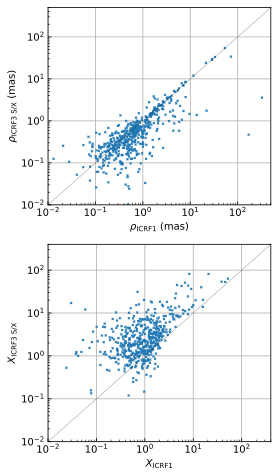

In [20]:
fig, (ax0, ax1) = plt.subplots(figsize=(4, 8), nrows=2)

# Angular separation
ax0.plot(com_sou_1v3sx["ang_sep_1"], com_sou_1v3sx["ang_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.01, 500, 2**0.2)
ax0.plot(x, x, "k", lw=0.2)

ax0.set_xlim([0.01, 500])
ax0.set_ylim([0.01, 500])
ax0.set_xscale("log")
ax0.set_yscale("log")

ax0.set_xlabel("$\\rho_{\\rm ICRF1}$ (mas)")
ax0.set_ylabel("$\\rho_{\\rm ICRF3\ S/X}$ (mas)")
ax0.grid()

# Normalized separation
ax1.plot(com_sou_1v3sx["nor_sep_1"], com_sou_1v3sx["nor_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.01, 400, 2**0.2)
ax1.plot(x, x, "k", lw=0.2)

ax1.set_xlim([0.01, 400])
ax1.set_ylim([0.01, 400])
ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlabel("$X_{\\rm ICRF1}$")
ax1.set_ylabel("$X_{\\rm ICRF3\ S/X}$")
ax1.grid()


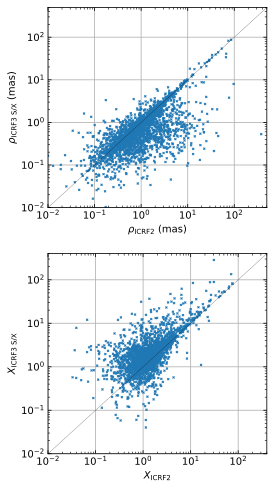

In [28]:
fig, (ax0, ax1) = plt.subplots(figsize=(4, 7), nrows=2)

# Angular separation
ax0.plot(com_sou_2v3sx["ang_sep_2"], com_sou_2v3sx["ang_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.01, 500, 2**0.2)
ax0.plot(x, x, "k", lw=0.2)

ax0.set_xlim([0.01, 500])
ax0.set_ylim([0.01, 500])
ax0.set_xscale("log")
ax0.set_yscale("log")

ax0.set_xlabel("$\\rho_{\\rm ICRF2}$ (mas)")
ax0.set_ylabel("$\\rho_{\\rm ICRF3\ S/X}$ (mas)")

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax0.grid()

# Normalized separation
ax1.plot(com_sou_2v3sx["nor_sep_2"], com_sou_2v3sx["nor_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.01, 400, 2**0.2)
ax1.plot(x, x, "k", lw=0.2)

ax1.set_xlim([0.01, 400])
ax1.set_ylim([0.01, 400])
ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlabel("$X_{\\rm ICRF2}$")
ax1.set_ylabel("$X_{\\rm ICRF3\ S/X}$")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax1.grid()

plt.tight_layout()

plt.savefig("../plots/sep_icrf2_vs_icrf3.eps")

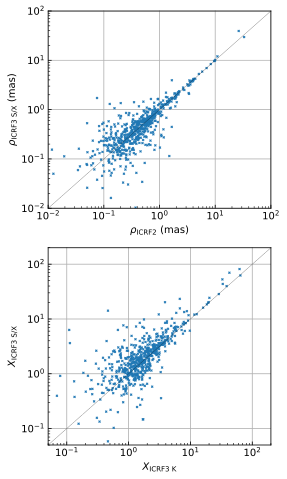

In [22]:
fig, (ax0, ax1) = plt.subplots(figsize=(4, 8), nrows=2)

# Angular separation
ax0.plot(com_sou_3kv3sx["ang_sep_3k"], com_sou_3kv3sx["ang_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.01, 100, 2**0.2)
ax0.plot(x, x, "k", lw=0.2)

ax0.set_xlim([0.01, 100])
ax0.set_ylim([0.01, 100])
ax0.set_xscale("log")
ax0.set_yscale("log")

ax0.set_xlabel("$\\rho_{\\rm ICRF2}$ (mas)")
ax0.set_ylabel("$\\rho_{\\rm ICRF3\ S/X}$ (mas)")
ax0.grid()

# Normalized separation
ax1.plot(com_sou_3kv3sx["nor_sep_3k"], com_sou_3kv3sx["nor_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.05, 200, 2**0.2)
ax1.plot(x, x, "k", lw=0.2)

ax1.set_xlim([0.05, 200])
ax1.set_ylim([0.05, 200])
ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlabel("$X_{\\rm ICRF3\ K}$")
ax1.set_ylabel("$X_{\\rm ICRF3\ S/X}$")
ax1.grid()


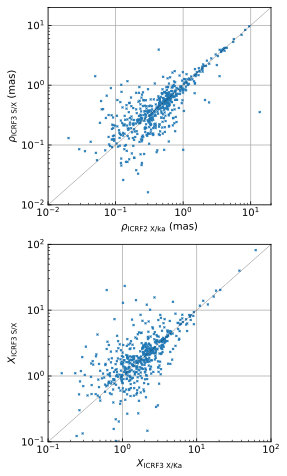

In [23]:
fig, (ax0, ax1) = plt.subplots(figsize=(4, 8), nrows=2)

# Angular separation
ax0.plot(com_sou_3xkav3sx["ang_sep_3xka"], com_sou_3xkav3sx["ang_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.01, 100, 2**0.2)
ax0.plot(x, x, "k", lw=0.2)

ax0.set_xlim([0.01, 20])
ax0.set_ylim([0.01, 20])
ax0.set_xscale("log")
ax0.set_yscale("log")

ax0.set_xlabel("$\\rho_{\\rm ICRF2\ X/ka}$ (mas)")
ax0.set_ylabel("$\\rho_{\\rm ICRF3\ S/X}$ (mas)")
ax0.grid()

# Normalized separation
ax1.plot(com_sou_3xkav3sx["nor_sep_3xka"], com_sou_3xkav3sx["nor_sep_3sx"], "x", ms=2)
# Plot y=x
x = np.arange(0.05, 200, 2**0.2)
ax1.plot(x, x, "k", lw=0.2)

ax1.set_xlim([0.1, 100])
ax1.set_ylim([0.1, 100])
ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlabel("$X_{\\rm ICRF3\ X/Ka}$")
ax1.set_ylabel("$X_{\\rm ICRF3\ S/X}$")
ax1.grid()
